# 定制化训练：基础
这是所有优化问题的基础！ 建立模型，寻找模型的参数。\
方法为：利用对loss function中的模型参数求导数，去定梯度。迭代下降。

实现为：
1. model主要是用来定义数学模型的（用线性还是多项式来拟合模型），一个callable的class，__call__中定义了函数的参数模型。
2. loss function，定义了(pred(model) - true)
3. optimizer实现两个功能。
    1. 对参数求导：求的是loss function对param的导数
    2. 迭代更改参数：param_new = old_param + （-梯度）*步长

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # Colab only
  %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

## Tensor

In [2]:
# 使用 python 状态
x = tf.zeros([10, 10])
# 等价于 x = x + 2, 不改变原本 x 的值
x +=2  
print(x)

tf.Tensor(
[[2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2.]], shape=(10, 10), dtype=float32)


## variable
variable是一个object,而这个obj不但存储着数值，而且自身就有一些method，可以直接对里面存储对数值做一些操作。\
可以理解为是一个封装了的数值。

于constant不同的是，constant需要手动watch，而variable会被GradientTape自动跟踪。我们不需要手动watch variable.\
当计算梯度时，会自动跟踪使用变量的计算过程。用变量来表示向量时，TensorFlow 会默认使用稀疏更新，这样可以带来计算和存储高效性。

In [3]:
v = tf.Variable(1.0)
assert v.numpy() == 1.0
#当我们给variable初始化的时候，可以给变量赋值



# 重新赋值
v.assign(3.0)
assert v.numpy() == 3.0
#我们利用assign函数对变量重新赋值。（这就是obj和primite的区别）

# 在 TensorFlow 操作中使用 `v`，比如  tf.square() 和重新赋值
v.assign(tf.square(v))
assert v.numpy() == 9.0

## 建立一个线性模型。
我们使用低级API（Tensor，Variable，GradientTape）来自定义一个线性模型。

常用的步骤如下：
1. 定义模型
2. 定义loss function
3. 获取dataset
4. 通过dataset，利用optimizer来调整变量的值来优化loss function。

### 定义模型
我们可以把模型封装在class里面，从而让代码更加的模块化。

In [4]:
# 初值 model(x) = 5*x + 0
class Model(object):
    def __init__(self):
        self.W = tf.Variable(5.0)  #都直接定义成variable的形式，让微分器自动的去追踪
        self.b = tf.Variable(0.0)
        
    def __call__(self,x):          #这是一个可以被call的class
        return self.W*x+self.b
    


尝试一下

In [5]:
model = Model()##实例化调用的是init函数
model(3).numpy()#call的时候执行的是__call__函数。

15.0

### Loss function
建立函数：loss(model_output,label)\
在tensorflow里面reduce前缀都表示降维度计算，而默认的维度是降为一维度。也可以选择按行或者按列降低维度。

In [6]:
def loss(predicted_y,desired_y):
    return tf.reduce_mean(tf.square(predicted_y - desired_y))

试一下

In [7]:
loss(3,4).numpy()

1

### 创建训练的dataset（with noise）

In [8]:
#训练函数方程是 f(x) = 3*x+2
TRUE_W = 3.0
TRUE_b = 2.0
NUM_EXAMPLES = 1000

inputs  = tf.random.normal(shape=[NUM_EXAMPLES])#x
noise   = tf.random.normal(shape=[NUM_EXAMPLES])#noise
outputs = inputs * TRUE_W + TRUE_b + noise #3*x+b+noise

#这里由于用完全相同的函数随机生成的，noise的平均值并不一定比input的平均值小。

In [9]:
import matplotlib.pyplot as plt

plt.scatter(inputs, outputs, c='b')
plt.scatter(inputs, model(inputs), c='r')
plt.show()

print('Current loss: '),
print(loss(model(inputs), outputs).numpy())

<Figure size 640x480 with 1 Axes>

Current loss: 
9.239105


### 定义optimizer
optimizer的作用是，每次使用optimizer一次，都会完成一步的优化。

optimizer的设置可以直接利用tf.train.Optimizer来实现，里面有大量已经写好的optimizer。这里我们先自己写。

写梯度下降法的思想是：
1. 在微分器中建立loss function与变量weight和bias之间的关系，常量是input，output.\
    具体方程为：new_loss = loss(model(input)，real_label)
    
    
2. 调用微分器求出loss function的偏导数。


3. 更改model中变量的值。\
    new_value = value - step_length * dx
    
    
其思路是：利用用gradientTape来求loss function(model输出于真实输出的差值) 对 model(数学模型）中的系数的梯度。 而后用梯度作为方向，取一个步长来下降。

In [16]:
def optimizer(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as t:
        current_loss = loss(model(inputs),outputs)
        #知识点：我们通过函数的调用即model()，可以在允许在微分器里面调入跳出
        #因此，这里lossfunction是关于variable.W,与variable.b的函数。
        #input和output不会被追踪，因为他们是constant（primate）类型
        #tape只最终variable和watch的对象。
        
    dw,db = t.gradient(current_loss,[model.W,model.b])
    #又是一个知识点，正如上面所说，微分器会自动记录所有参与到计算的variable的微分情况
    #这里可以用list的形式来分别求导并分别赋值。
    
    model.W.assign_sub(learning_rate*dw)
    model.b.assign_sub(learning_rate*db)
    #知识点again！tf.variable.assign_sub
    #var.assign_sub(delta)等于 var = var - delta!
    #而当delta = dw * step_length的时候，就是优化算法了！！wonderful！！！
    

### 迭代训练
迭代训练的实现是基于不断的调用optimizer。每调用一次optimizer，梯度下降法下降一个步长。

Epoch  0: W=5.00 b=0.00, loss=9.23911
Epoch  1: W=4.17 b=0.80, loss=3.89950
Epoch  2: W=3.67 b=1.28, loss=2.02397
Epoch  3: W=3.37 b=1.56, loss=1.36515
Epoch  4: W=3.20 b=1.72, loss=1.13371
Epoch  5: W=3.09 b=1.82, loss=1.05240
Epoch  6: W=3.03 b=1.88, loss=1.02383
Epoch  7: W=2.99 b=1.91, loss=1.01379
Epoch  8: W=2.97 b=1.93, loss=1.01026
Epoch  9: W=2.96 b=1.94, loss=1.00902


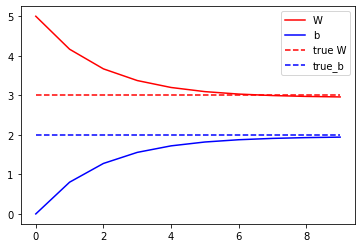

In [17]:
model = Model()

# 收集 W 和 b 的历史数值，用于显示
Ws, bs = [], []
epochs = range(10)
for epoch in epochs:
    ##作图所用
    Ws.append(model.W.numpy())
    bs.append(model.b.numpy())
    current_loss = loss(model(inputs), outputs)
    ##作图记录点
    
   
    ##真正的训练只需要这一句话，调用optimizor就够了。
    optimizer(model, inputs, outputs, learning_rate=0.2)
    
    
    print('Epoch %2d: W=%1.2f b=%1.2f, loss=%2.5f' %
        (epoch, Ws[-1], bs[-1], current_loss))

# 显示所有
plt.plot(epochs, Ws, 'r',
         epochs, bs, 'b')
plt.plot([TRUE_W] * len(epochs), 'r--',
         [TRUE_b] * len(epochs), 'b--')
plt.legend(['W', 'b', 'true W', 'true_b'])
plt.show()